## Unconditional Diffusion Model

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from typing import List, Dict, Tuple, Set, Union, Optional, Any, Callable

os.chdir('/scratch/x2895a03/research/md-diffusion/Ashesh')

In [3]:
import ase
from ase import units
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [122]:
temperature = 1000

#uncond=np.load(f'./results/Diffusion_MD_trial_egnn_3lr_3e-4_t250_1000_{temperature}K.npz')

#exp_name = "Diffusion_MD_trial_egnn_3lr_1e-4_t250_300K_pbc_less_force_2_501_50_short"

''' case 1~8
md_ep2501_one_step_noise_single_temp_[1000]K_T300_lr0.001_orig_one_step_T
md_ep2501_one_step_noise_single_temp_[1000]K_T300_lr0.001_orig_next_frame_T
md_ep2501_one_step_noise_single_temp_[1000]K_T300_lr0.001_lazy_one_step -> meh..
md_ep2501_one_step_noise_single_temp_[1000]K_T300_lr0.001_lazy_one_step_diff -> good

md_ep2501_one_step_noise_single_temp_[300]K_T300_lr0.001_one_step_T
md_ep2501_one_step_noise_single_temp_[300]K_T300_lr0.001_next_frame_T
md_ep2501_one_step_noise_single_temp_[300]K_T300_lr0.001_lazy_one_step_T
md_ep2501_one_step_noise_single_temp_[300]K_T300_lr0.001_lazy_one_step_diff_T
'''

''' direct pred
md_ep2501_one_step_noise_single_temp_[1000]K_T300_lr0.001_orig_direct_T
md_ep2501_one_step_noise_    single_temp_[300]K_T300_lr0.001_direct_T
'''

''' multiple temp
 md_ep2501_one_step_noise_single_temp_[300, 500, 1000]K_T300_lr0.001_lazy_one_step_diff
 md_ep2501_one_step_noise_single_temp_[300, 500, 1000]K_T300_lr0.001_lazy_one_step -> meh..

 test on 200K
 md_ep2501_one_step_noise_    single_temp_[300, 500, 1000]K_T300_lr0.001_one_step_[200]K
'''


exp_name = "md_ep2501_one_step_noise_single_temp_[300, 500, 1000]K_T300_lr0.001_lazy_one_step_diff"
# f"predicted_diffusion_md_recursive_t_random_multi_temp_{temperature}K"
uncond = np.load(f'./results/single_temp/{exp_name}.npz')

In [123]:
uncond.files

['arr_0', 'arr_1']

In [124]:
print(uncond['arr_0'].shape)
uncond_pre = uncond['arr_0'][:, 0, ...] # np.mean(uncond['arr_0'], axis=1)
print(uncond_pre.shape)
# uncond_pre = uncond['pred'][:, :, 1, :, :, :  ] * 25

(2000, 1, 1, 64, 9)
(2000, 1, 64, 9)


hard sphere collision -> 특정 시점에서 force가 매우 크게 들어옴? <br>
force 떼고 학습시키거나 추론하는 branch 따로 만들어야 하나? <br>
(+) 초기 코드는 force 학습은 분명히 안했음 <br>

0205 기준 velocity도 떼고 하는 실험 돌림

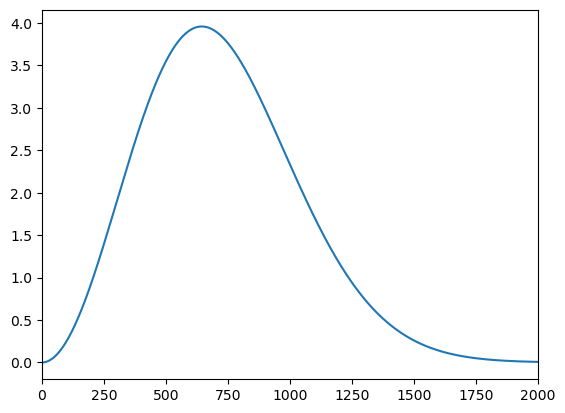

In [125]:
# plot maxwell-boltzmann distribution
v_max = 2000
v = np.linspace(0, v_max, 10000)
m = 40 * 1.66053906660e-27
T = temperature
k = 1.38064852e-23
f = v**2 * np.sqrt(m / (2 * np.pi * k * T))**(3/2) * np.exp(-m * v**2 / (2 * k * T))
plt.plot(v, f)
plt.xlim(0, v_max)
plt.show()

In [126]:
uncond_gt = uncond['arr_1'][:, ...] # 'GT'
print(uncond_gt.shape)

(2000, 1, 64, 9)


In [127]:
print(units.fs)

0.09822694788464063


In [128]:
def get_velocity_from_pos(pos, dt =2.5):
    return (pos[1:] - pos[:-1]) / dt
vels_from_pos = get_velocity_from_pos(uncond_pre[..., :3], dt = 2.5 ) * 1e5
vels_from_pos = np.concatenate((vels_from_pos, vels_from_pos[-1:]), axis=0)
gt_vels_from_pos = get_velocity_from_pos(uncond_gt[..., :3], dt = 2.5) * 1e5 
gt_vels_from_pos = np.concatenate((gt_vels_from_pos, gt_vels_from_pos[-1:]), axis=0)
print(vels_from_pos.shape, gt_vels_from_pos.shape)

(2000, 1, 64, 3) (2000, 1, 64, 3)


(10, 200, 1, 64)


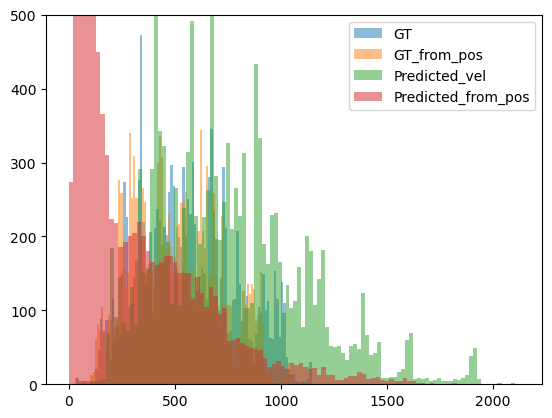

In [131]:
# extract valocities and chunk 
vels_gt = uncond_gt[..., -3:] 
n_chunks = 10
vels_gt = np.array_split(vels_gt, n_chunks, axis=0)
vels_pred = uncond_pre[..., -3:]
vels_pred = np.array_split(vels_pred, n_chunks, axis=0)

# magnitude of velocity
vels_mag = np.linalg.norm(vels_gt, axis=-1) * units.fs * 1e5
print(vels_mag.shape)
vels_mag = np.reshape(vels_mag, (n_chunks, -1))


vels_mag_pred = np.linalg.norm(vels_pred, axis=-1) * units.fs * 1e5
vels_mag_pred = np.reshape(vels_mag_pred, (n_chunks, -1))

vels_mag_from_pos = np.linalg.norm(vels_from_pos, axis=-1)
vels_mag_from_pos = np.reshape(vels_mag_from_pos, (10, -1)) # pos에서 계산한건 frame 하나 없음

gt_vels_mag_from_pos = np.linalg.norm(gt_vels_from_pos, axis=-1)
gt_vels_mag_from_pos = np.reshape(gt_vels_mag_from_pos, (10, -1)) 


bin_idx = 0
plt.hist(vels_mag[bin_idx], bins=100, alpha=0.5, label='GT')
plt.hist(gt_vels_mag_from_pos[bin_idx], bins=100, alpha=0.5, label='GT_from_pos')
plt.hist(vels_mag_pred[bin_idx], bins=100, alpha=0.5, label='Predicted_vel')
plt.hist(vels_mag_from_pos[bin_idx], bins=100, alpha=0.5, label='Predicted_from_pos')


#plt.xlim(0, 10000)
plt.ylim(0,500)
plt.legend()
plt.show()

In [130]:
vels_mag_pred.shape

(10, 12800)

In [132]:
# extract valocities and chunk 
vels_GT = uncond_gt[:200, ..., -3:]
vels_from_pos_plot = vels_mag_from_pos
n_chunks = 10

# magnitude of velocity(GT)
vels_mag_GT = np.linalg.norm(vels_GT, axis=-1) * units.fs * 1e5
print(vels_mag_GT.shape)
vels_mag_GT = np.reshape(vels_mag_GT, (n_chunks//4, -1))


vels = uncond_pre[..., -3:] * units.fs * 1e5
vels = np.array_split(vels, n_chunks, axis=0)
#print("vels pred shape", vels.shape)
# magnitude of velocity(inference)
vels_mag = np.linalg.norm(vels, axis=-1)
print(vels_mag.shape)
# vels_mag = np.reshape(vels_mag, (n_chunks*10, -1))

vel_to_plot_GT = vels_mag_GT[0].flatten()
vel_to_plot = vels_mag_from_pos[0].flatten()
vel_to_plot_mid = vels_mag_from_pos[4].flatten()
vel_to_plot_end = vels_mag_from_pos[-1].flatten()

# figsize = 21, 6
plt.figure(figsize=(8, 5))

# m-b fitting
def maxwell_boltzmann_velocity(v, T, scale):
    m = 39.948 * units._amu  # Mass of Argon in kg
    kb = units.kB * units._e  # Boltzmann constant in J/K
    return scale * (m / (2 * np.pi * kb * T))**(3/2) * 4 * np.pi * v**2 * np.exp(-m * v**2 / (2 * kb * T))

# # GT and GT fit
# plt.hist(vel_to_plot_GT, bins=100, alpha=0.3, label=f'GT, $\mu$ = {np.mean(vel_to_plot_GT):.2f}', color = 'b')
# plt.plot(v, f * 40, label=f'Maxwell-Boltzmann, $\mu$ = {2 * np.sqrt((2 * k * T) / m / np.pi):.2f}')

# mu_0 and mu_0 fit
plt.hist(vel_to_plot, bins=100, alpha=0.2, label=f'inference, $\mu_0$ = {np.mean(vel_to_plot):.2f}', color = 'r')
hist, bin_edges = np.histogram(vel_to_plot, bins=1000, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
popt, _ = curve_fit(maxwell_boltzmann_velocity, bin_centers, hist, p0=[10000 , np.amax(hist)])
plt.plot(bin_centers, maxwell_boltzmann_velocity(bin_centers, *popt) * 3e5, 'r-', label=f'$\mu_0$ Fit (T = {popt[0]:.2f} K)')

# mu_4 and mu_4 fit
plt.hist(vel_to_plot_mid, bins=100, alpha=0.2, label=f'inference, $\mu_4$ = {np.mean(vel_to_plot_mid):.2f}', color = 'g')
hist_mid, bin_edges_mid = np.histogram(vel_to_plot_mid, bins=100, density=True)
bin_centers_mid = (bin_edges_mid[:-1] + bin_edges_mid[1:]) / 2
popt, _ = curve_fit(maxwell_boltzmann_velocity, bin_centers_mid, hist_mid, p0=[10000 , np.amax(hist_mid)])
plt.plot(bin_centers_mid, maxwell_boltzmann_velocity(bin_centers_mid, *popt) * 3e5, 'g-', label=f'$\mu_4$ Fit (T = {popt[0]:.2f} K)')

# mu_9 and mu_9 fit
plt.hist(vel_to_plot_end, bins=100, alpha=0.2, label=f'inference, $\mu_9$ = {np.mean(vel_to_plot_end):.2f}', color = 'b')
hist_end, bin_edges_end = np.histogram(vel_to_plot_end, bins=100, density=True)
bin_centers_end = (bin_edges_end[:-1] + bin_edges_end[1:]) / 2
popt, _ = curve_fit(maxwell_boltzmann_velocity, bin_centers_end, hist_end, p0=[10000 , np.amax(hist_end)])
plt.plot(bin_centers_end, maxwell_boltzmann_velocity(bin_centers_end, *popt) * 3e5, 'b-', label=f'$\mu_9$ Fit (T = {popt[0]:.2f} K)')

#plt.hist(vel_to_plot_mid, bins=100, alpha=0.3, label='inference, $\mu_4$'+f' = {np.mean(vel_to_plot_mid):.2f}')
#plt.hist(vel_to_plot_end, bins=110, alpha=0.3, label='inference, $\mu_9$'+f' = {np.mean(vel_to_plot_end):.2f}')

plt.xlim(0, v_max)
#plt.ylim(0, 320)
plt.xlabel('Velocity (m/s)')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [78]:
print(uncond_pre[..., :3].shape)
print(uncond_gt[..., :3].shape)

(2000, 1, 64, 3)
(2000, 1, 64, 3)


# Difference Between Pred and GT Distributions

## MSD plot 

In [109]:
# displacement distribution
pos_gt = uncond_gt[..., :3].squeeze()
pos_pred = uncond_pre[..., :3].squeeze()

def get_displacement_from_pos(pos):
    # pos: (n_frames, n_atoms, 3)
    # return : displacement (n_frames, n_atoms, n_atoms)
    n_frames, n_atoms, _ = pos.shape
    pos = pos.reshape(n_frames, n_atoms, 1, 3)
    displacement = pos - pos.transpose(0, 2, 1, 3)
    return np.sqrt(np.sum(displacement**2, axis=-1))

def get_framewise_displacement_from_pos(pos):
    # pos: (n_frames, n_atoms, 3)
    # return : msd (n_frames)
    num_frames = pos.shape[0]
    msd = np.zeros(num_frames)

    for t in range(num_frames):
        total_displacement = 0.0
        count = 0

        for rel_time in range(num_frames - t):
            displacement = pos[t + rel_time] - pos[rel_time]  
            squared_displacement = np.sum(displacement**2, axis=1)  
            total_displacement += np.mean(squared_displacement)  
            count += 1

        msd[t] = total_displacement / count if count > 0 else 0.0

    return msd


# displacement_gt = get_displacement_from_pos(pos_gt)
# displacement_pred = get_displacement_from_pos(pos_pred)
print(pos_gt.shape)
displacement_gt_framewise = get_framewise_displacement_from_pos(pos_gt)
displacement_pred_framewise = get_framewise_displacement_from_pos(pos_pred)

(2000, 64, 3)


In [110]:
print(displacement_gt_framewise.shape)

(2000,)


(2000,)


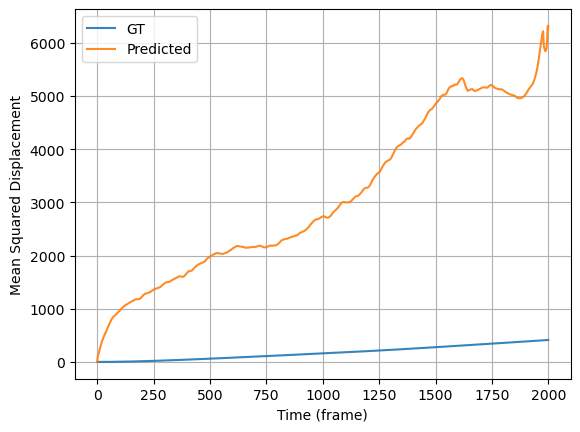

In [111]:
print(displacement_pred_framewise.shape)
plt.plot(np.arange(2000), displacement_gt_framewise.flatten(), alpha=0.9, label='GT')
plt.plot(np.arange(2000), displacement_pred_framewise.flatten() , alpha=0.9, label='Predicted')
plt.ylabel('Mean Squared Displacement')
plt.xlabel('Time (frame)')
plt.legend()
plt.grid()
plt.show()

In [36]:
print(displacement_pred_framewise)

[   0.           31.09095236   70.02188539 ... 1301.76945522 1275.40967733
 1238.094228  ]


## Position plot 

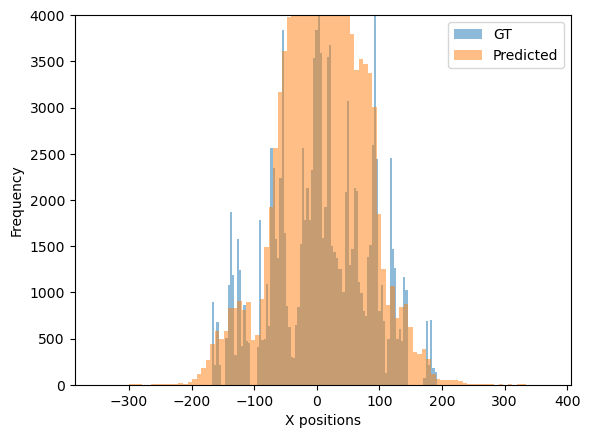

In [112]:
gt_pos = uncond_gt[..., :3]
pred_pos = uncond_pre[..., :3]

plt.hist(gt_pos[..., 0].flatten(), bins=100, alpha=0.5, label='GT')
plt.hist(pred_pos[..., 0].flatten(), bins=100, alpha=0.5, label='Predicted')
plt.ylabel('Frequency')
plt.xlabel('X positions')
plt.legend()
plt.ylim(0, 4000)
plt.show()

In [87]:
# check is nan
print(np.isnan(vel_to_plot).any())
print(vel_to_plot.shape)
print("mas and min", np.max(vel_to_plot), np.min(vel_to_plot))
print(vel_to_plot[:100], vel_to_plot_GT[-100:])

False
(12800,)
mas and min 2357.2963975419875 5.695915711555854
[216.10560545  41.47259514 152.62012539 327.66872999  55.74476347
  32.4943329   40.84821063  36.43936749 153.57879318 157.35197353
 805.61590872 200.26155657  30.59323209  34.26484298  61.64747272
 106.46646479 696.96223151  37.13611372  82.53198502  74.29319655
 346.07649103 453.6023434  151.36140159  34.68744796  62.97881892
 747.13564898  79.05643373 509.58585482  24.96442706  50.98797116
 537.54415437 556.51983676 164.86799707  70.65809766  38.15370167
  24.41127054 410.660165   414.61607507  23.01742507 266.53569448
  38.43129543  50.77130621  32.14897368  33.25583725 565.83907065
  35.40880554 155.55455449 395.73417473  40.37818619  22.03275467
  35.58081226 243.88482041  11.56040866  32.3921355  388.10609998
  20.62628876 112.63379471 150.48736826 513.74662977 209.03157544
 115.5732499   34.32912198  16.27428466  25.03568108 213.49993519
  32.96754967 134.8212685  374.80575669  51.47610614  31.62844606
  41.6292371

## Export to extxyz(optional)

In [88]:
import numpy as np
from ase import Atoms, units
from ase.io import write

# 예시 데이터 생성 (2000 프레임, 각 프레임은 (1, 64, 3) 형태)
data = uncond_gt[..., :3]

# 원자 종류 설정 (예: 수소 원자 64개)
symbols = ['Ar'] * 64
L = 10.0  # 박스 크기를 적절한 값으로 조정하세요
supercell_size = (4,4,4)
delta_t = 2.5 * units.fs

# extxyz 파일로 저장
# f'{exp_name}.extxyz'
with open(f'{exp_name}.extxyz', 'w') as f:
    for i, frame in enumerate(data):
        positions = frame[0]  # (64, 3) 형태의 원자 좌표
        
        # 직육면체 격자 설정 [Lx, Ly, Lz]
        # ASE에서는 cell이 3x3 행렬 또는 [Lx, Ly, Lz] 벡터로 정의됨
        cell = [L, L, L]
        
        # 원자 객체 생성 및 격자 설정
        atoms = Atoms(symbols=symbols, positions=positions, cell=cell)
        
        # 추가 정보 설정
        # 시간 정보 추가 (fs 단위)
        current_time = i * delta_t
        atoms.info['time'] = current_time
        atoms.info['timestep'] = i
        atoms.info['delta_t'] = delta_t
        
        write(f, atoms, format='extxyz')

In [89]:
print(np.shape(uncond_pre))
print(np.shape(uncond_gt))

(2000, 1, 64, 9)
(2000, 1, 64, 9)


In [90]:
uncond_pre = np.expand_dims(uncond_pre, 1)
print(uncond_pre.shape)
from tqdm import tqdm

(2000, 1, 1, 64, 9)


In [93]:
d1, d2, d3, d4 = np.shape(uncond_gt) # 512 1 64 9
print(d1, d2, d3, d4)
n_frames_to_draw = 1000

for trajs in range(1):
    # if os.path.exists("./results/long_diffusion_test_point_#"+str(idx)+"_traj_#"+str(trajs)+".png"):
    #     continue
    for idx in tqdm(range(n_frames_to_draw//5)):
        #idx = 12000 + idx * 10
        idx = idx * 5
        #print(idx)
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        # if idx < d1:
        #     for i in range(d3):
        #         if i == d3 -1:
        #             ax.scatter(uncond_gt[idx,0,i,0],uncond_gt[idx,0,i,1],uncond_gt[idx,0,i,2], marker='o', c='black', label="GT")
        #         else:    
        #             ax.scatter(uncond_gt[idx,0,i,0],uncond_gt[idx,0,i,1],uncond_gt[idx,0,i,2], marker='o', c='black')
        for i in range(d3):
            if i == d3 -1:
                ax.scatter(uncond_pre[idx,trajs,0,i,0],uncond_pre[idx,trajs,0,i,1],uncond_pre[idx,trajs,0,i,2], marker='*', c='red', label="Pre")
            else:
                ax.scatter(uncond_pre[idx,trajs,0,i,0],uncond_pre[idx,trajs,0,i,1],uncond_pre[idx,trajs,0,i,2], marker='*', c='red')

        ax.set_title('Test trajectory #'+str(trajs)+',  t = #'+str(idx))
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()
        plt.savefig("./results/figs/long_diffusion_test_point_#"+str(idx)+"_traj_#"+str(trajs)+".png")    
        plt.close()

2000 1 64 9


100%|██████████| 200/200 [00:46<00:00,  4.28it/s]


In [95]:
# generate gif with saved figs
import imageio
#n_frames_to_draw = 200
# long_diffusion_12000_14000_200K
# 12000 + idx * 10
#with imageio.get_writer(f'./results/predicted_diffusion_md_one_step_t_random_{temperature}K.gif', mode='I') as writer:
with imageio.get_writer(f'./results/{exp_name}.gif', mode='I') as writer:
    for filename in ["./results/figs/long_diffusion_test_point_#"+str(idx*5)+"_traj_#0"+".png" \
    for idx in range(200)]:
        image = imageio.imread(filename)
        writer.append_data(image)

/tmp/ipykernel_39786/1066886961.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


# GT data

(10000, 64, 9)


In [60]:
### DONT EXECUTE THIS PART 
import imageio
# Generate figure for the first 10k frames with stride 4
for idx in range(200):
    idx = idx * 5 
    # if os.path.exists("./results/GT_figs/diffusion_gt_test_point_#"+str(idx)+".png"):
    #     continue

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    for i in range(64):
        if i == 63:
            ax.scatter(x_tensor[idx,i,0],x_tensor[idx,i,1],x_tensor[idx,i,2], marker='o', c='black', label="GT")
        else:
            ax.scatter(x_tensor[idx,i,0],x_tensor[idx,i,1],x_tensor[idx,i,2], marker='o', c='black')
    ax.set_title('GT trajectory,  t = #'+str(idx))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    if not os.path.exists("./results/GT_figs"):
        os.makedirs("./results/GT_figs")
    plt.savefig("./results/GT_figs/diffusion_gt_test_point_#"+str(idx)+".png")    
    plt.close()

# generate gif with saved figs
with imageio.get_writer('./results/GT_1000K.gif', mode='I') as writer:
    for filename in ["./results/GT_figs/diffusion_gt_test_point_#"+str(idx * 5)+".png" for idx in range(500)]:
        image = imageio.imread(filename)
        writer.append_data(image)

/tmp/ipykernel_58160/2027591225.py:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


FileNotFoundError: No such file: '/scratch/x2895a03/research/md-diffusion/Ashesh/results/GT_figs/diffusion_gt_test_point_#1005.png'

In [26]:
x_tensor[0].shape

(64, 9)

In [27]:
def pbc_coord(coord: torch.Tensor, lattice: torch.Tensor) -> torch.Tensor:
    """
    Apply periodic boundary condition to the coordinates.
    Args:
        coord (torch.Tensor): The coordinates to apply PBC to. The shape is (batch_size, num_atoms, 3).
        lattice (torch.Tensor): The lattice vectors. The shape is (batch_size, 3, 3).
    Returns:
        torch.Tensor: The coordinates after applying PBC. The shape is (batch_size, num_atoms, 3).
    """
    # Calculate the fractional coordinates
    fractional_coord = torch.einsum('bji,bni->bnj', torch.inverse(lattice), coord)
    # Apply PBC
    fractional_coord = fractional_coord - torch.round(fractional_coord)
    # Convert back to Cartesian coordinates
    coord = torch.einsum('bji,bnj->bni', lattice, fractional_coord)
    return coord

def compute_min_distance_pbc_single_cell(
                    coord1: torch.Tensor,  # (batch, num_atom, 3)
                    coord2: torch.Tensor,  # (batch, num_atom, 3)
                    lattice1: torch.Tensor,  # (batch, 3, 3) lattice vectors for coord1 (GT)
                    lattice2: torch.Tensor,  # (batch, 3, 3) optional lattice for coord2 (Pred)
                    mask: torch.Tensor,
                    cutoff: float = 5,
                    eps: float = 1e-6,
                    return_disp: bool = False,
                    num_image_cell: int = 1) -> Tuple[torch.Tensor, torch.Tensor, Optional[torch.Tensor], Optional[torch.Tensor]]:
    
    if lattice1 is None and lattice2 is None:
        return comput_disp(coord1, coord2, mask, cutoff, eps)

    #print("coord shape: ", coord1.shape)
    batch_size, num_atoms, _ = coord1.shape
    # Normalize the coord (move into the unit cell)
    #print('coord before pbc_coord: ', coord)
    #coord = pbc_coord(coord, lattice)
    #print('coord after pbc_coord: ', coord)
    # if self.max_neighbor is not None:
    # Step 1: Generate relative cell displacement vectors
    # num_image_cell:1 -> (3x3x3) shift vectors
    # num_image_cell:3 -> (7x7x7) shift vectors
    # n_img == num_image_cell**3
    # print("lattice and coord shape : ", lattice1.shape, coord1.shape)

    # step 1: Generate relative cell displacement vectors
    shifts = torch.stack(torch.meshgrid(
        torch.arange(-num_image_cell, num_image_cell + 1),  # Neighbor cells in x
        torch.arange(-num_image_cell, num_image_cell + 1),  # Neighbor cells in y
        torch.arange(-num_image_cell, num_image_cell + 1),   # Neighbor cells in z
    indexing="ij"), dim=-1).reshape(-1, 3).type(coord1.dtype).to(coord1.device)  
    # shift = [0,0,0] index
    r_000_index = torch.where(torch.all(shifts == 0, dim=-1))[0].item()
    num_images = shifts.shape[0]
    # Apply lattice vectors to get Cartesian displacements for the 27 neighbor cells
    # The shape should be (batch_size, 27, 3), where lattice has shape (batch_size, 3, 3) and shifts has shape (27, 3)
    # print("shifts shape: ", shifts.shape)
    r_vector_1 = torch.einsum('nj, bji->bni', shifts, lattice1)  # (batch_size, 27, 3)
    r_vector_2 = torch.einsum('nj, bji->bni', shifts, lattice2)
    # print("r_vector shape: ", r_vector.shape)
        
    # Step 2: calculate distance btw original(coord1) and noised coord pbc (coord2_ext)
    # coord1_ext = coord1.unsqueeze(2) + r_vector_1.unsqueeze(1)  # (batch_size, num_atoms, n_img, 3)
    coord1_ext = coord1.unsqueeze(2) + r_vector_1.unsqueeze(1)  # (batch_size, num_atoms, n_img, 3)
    disp_1 = coord1_ext.unsqueeze(2) - coord1.unsqueeze(1).unsqueeze(3)
    coord2_ext = coord2.unsqueeze(2) + r_vector_2.unsqueeze(1)  # (batch_size, num_atoms, n_img, 3)
    disp_2 = coord2_ext.unsqueeze(2) - coord2.unsqueeze(1).unsqueeze(3)
    
    
    self_min_disp = torch.sqrt(torch.sum(disp_1 ** 2, dim=-1))  # (batch_size, num_atoms, num_atoms, n_img)
    
    #print("self min disp shape: ", self_min_disp.shape)

    min_dist, min_idx = torch.min(self_min_disp, dim=-1)  # (batch_size, num_atoms, num_atoms)
    min_disp = torch.gather(disp_1, 3,  min_idx.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, -1, 1, 3))
    
    #return disp
    return min_dist, min_disp, min_idx


device ="cpu" # torch.device("cuda" if torch.cuda.is_available() else "cpu")
cell_vector = torch.tensor([[[21.04, 0.0, 0.0], [0.0, 21.04, 0.0], [0.0, 0.0, 21.04]]], device=device)
coord1 = torch.from_numpy(x_tensor[1000:1002, :, :3]).to(device).float()
coord2 = torch.from_numpy(x_tensor[1000:1002, :, :3]).to(device).float()
min_dist_single_cell, min_disp_single_cell, min_idx_single_cell = \
    compute_min_distance_pbc_single_cell(coord1, coord2, cell_vector, cell_vector, mask=None)
print(min_disp_single_cell.shape)

torch.Size([2, 64, 64, 1, 3])


In [28]:
vec_difference = []
for i in range(5000, 25000):
    coord1 = torch.from_numpy(x_tensor[i:i+1, :, :3]).to(device).float()
    coord1 = pbc_coord(coord1, cell_vector)
    coord2 = torch.from_numpy(x_tensor[i:i+1, :, :3]).to(device).float()
    coord2 = pbc_coord(coord2, cell_vector)
    min_dist_single_cell, min_disp_single_cell, min_idx_single_cell = \
        compute_min_distance_pbc_single_cell(coord1, coord2, cell_vector, cell_vector, mask=None)
    vec_difference.append(np.mean(min_dist_single_cell.cpu().detach().numpy()))

plt.plot(vec_difference)

KeyboardInterrupt: 

In [ ]:
min_dist_single_cell.shape

torch.Size([2, 64, 64])

In [ ]:
coord1_pbc = pbc_coord(coord1, cell_vector)
print(coord1_pbc)

tensor([[[  1.0201,   1.9814,  -6.0188],
         [ -2.4328,  -2.1128,  -4.4550],
         [ -0.1289,   0.3778,   2.4622],
         [  1.1462,  -1.6272,  -4.8529],
         [ -5.4636,   4.3570,   1.6906],
         [  0.0815,   7.7222,   9.9612],
         [  6.8912,   0.0584, -10.4754],
         [  5.1695,   3.6115,  -9.8377],
         [ -2.8163,   7.1847,   1.2407],
         [  9.1299,  -7.9799,  -3.2584],
         [ -2.9740,   8.0036,   7.2613],
         [ -1.1984,  -7.4684,  -0.9964],
         [ -0.6014,  -4.1785,  -0.3202],
         [ -3.5899,  -7.6070,   3.2005],
         [  3.6976,  -4.4608,   8.0617],
         [ -1.4569,  -9.7679,   7.1971],
         [  7.9639,   1.9626,   1.2257],
         [  7.8107,   3.4569,   8.7944],
         [  8.8347,   2.9067,  -8.6647],
         [  4.2086,  -2.0946,  -8.1934],
         [ -0.1261,   6.5052,   4.5021],
         [  4.2660,   8.6567, -10.1287],
         [  3.8450,   4.4254,   7.2449],
         [  8.5897,   6.0888,  -0.3927],
         [  1.59

In [ ]:
torch.sqrt(torch.sum(min_disp_single_cell.squeeze()**2, -1))

tensor([[ 0.0000,  6.4037,  3.8313,  ...,  8.8433, 10.2151, 11.9957],
        [ 6.4037,  0.0000,  8.9623,  ..., 11.9629, 10.6630, 14.6291],
        [ 3.8313,  8.9623,  0.0000,  ...,  5.3643,  6.4464, 10.3749],
        ...,
        [ 8.8433, 11.9629,  5.3643,  ...,  0.0000,  4.6452,  5.4114],
        [10.2151, 10.6630,  6.4464,  ...,  4.6452,  0.0000,  6.9678],
        [11.9957, 14.6291, 10.3749,  ...,  5.4114,  6.9678,  0.0000]])

## Model Sanity Check

In [ ]:
from models.EGNN import * 
model = EGNN(in_dim=64,
            out_dim=9, # coord, force, vel output
            h_dim=128,
            num_layer=3,
            num_timesteps=250,
            update_coord='last',
            use_attention=True,
            num_head=4,
            use_condition=True,
            temperature=200)

In [ ]:
test_frane = torch.from_numpy(uncond_gt[0]).float()
test_coord = torch.from_numpy(uncond_gt[0][:, :, :3]).float()
rotation_matrix = torch.tensor([[1, 0, 0], [0, 0, 1], [0, -1, 0]] ).float() # 90 degree rotation around x-axis
rotation_matrix_inverse = torch.inverse(rotation_matrix)
test_coord_rotate = torch.matmul(test_coord, rotation_matrix)
test_coord_translate = test_coord + 10

test_coord_pbc = pbc_coord(test_coord, cell_vector)
test_coord_rotate_pbc = pbc_coord(test_coord_rotate, cell_vector)

# 1. check min distances
min_dist_test, min_disp_test, min_idx_test = \
    compute_min_distance_pbc_single_cell(test_coord, test_coord, cell_vector, cell_vector, mask=None)
min_dist_test_rotate, min_disp_test_rotate, min_idx_test_rotate = \
    compute_min_distance_pbc_single_cell(test_coord_rotate, test_coord_rotate, cell_vector, cell_vector, mask=None)
min_dist_test_translate, min_disp_test_translate, min_idx_test_translate = \
    compute_min_distance_pbc_single_cell(test_coord_translate, test_coord_translate, cell_vector, cell_vector, mask=None)

In [ ]:
print("difference btw raw and rotated : ", torch.sum((min_dist_test - min_dist_test_rotate)**2))
print("difference btw raw and translated : ", torch.sum((min_dist_test - min_dist_test_translate)**2))

difference btw raw and rotated :  tensor(1.1383e-09)
difference btw raw and translated :  tensor(6.5359e-09)


In [ ]:
print(min_disp_test_rotate.shape)

torch.Size([1, 64, 64, 1, 3])


In [ ]:
# 2. check displacements
min_disp_test_rotate_inverse = torch.matmul(min_disp_test_rotate, rotation_matrix_inverse)
print(min_disp_test_rotate_inverse.shape)
print("difference btw raw and rotated : ", torch.sum((min_disp_test - min_disp_test_rotate_inverse)**2))
print("difference btw raw and translated : ", torch.sum((min_disp_test - min_disp_test_translate)**2))

torch.Size([1, 64, 64, 1, 3])
difference btw raw and rotated :  tensor(0.)
difference btw raw and translated :  tensor(1.5182e-08)


In [ ]:
# 3. check model outputs
n_frames, n_atoms, n_features = test_frane.shape
mask = torch.ones((n_frames, n_atoms))

mask2d_test = min_dist_test < 10.0
mask2d_test_rotate = min_dist_test_rotate < 10.0
mask2d_test_translate = min_dist_test_translate < 10.0
t = torch.tensor([[0.0]])

x_force_speed_test = torch.from_numpy(uncond_gt[0][:, :, 3:]).float()
x_0_test = torch.cat([test_coord, x_force_speed_test], dim=-1)
print(x_0_test.shape)
# orig outputs
feat_noise_pred, coord_noise_pred = model(x_force_speed_test, test_coord_pbc, min_dist_test, min_disp_test, t.view(-1, 1), 
                                                adj_mat=mask2d_test, mask=mask, mask2d=mask2d_test, condition=x_0_test)
# rotated outputs
feat_noise_pred_rotate, coord_noise_pred_rotate = model(x_force_speed_test, test_coord_rotate_pbc, min_dist_test_rotate, min_disp_test_rotate, t.view(-1, 1),
                                                adj_mat=mask2d_test_rotate, mask=mask, mask2d=mask2d_test_rotate, condition=x_0_test)
# translated outputs
feat_noise_pred_translate, coord_noise_pred_translate = model(x_force_speed_test, test_coord_translate, min_dist_test_translate, min_disp_test_translate, t.view(-1, 1),
                                                adj_mat=mask2d_test_translate, mask=mask, mask2d=mask2d_test_translate, condition=x_0_test)
                                                

torch.Size([1, 64, 9])


In [ ]:
# coord noise difference
print("difference btw raw and rotated : ", torch.sum((coord_noise_pred - coord_noise_pred_rotate)**2))
print("difference btw raw and translated : ", torch.sum((coord_noise_pred - coord_noise_pred_translate)**2))

# feat noise difference
print("difference btw raw and rotated : ", torch.sum((feat_noise_pred - feat_noise_pred_rotate)**2))
print("difference btw raw and translated : ", torch.sum((feat_noise_pred - feat_noise_pred_translate)**2))

difference btw raw and rotated :  tensor(0.0038, grad_fn=<SumBackward0>)
difference btw raw and translated :  tensor(2.6604e-15, grad_fn=<SumBackward0>)
difference btw raw and rotated :  tensor(1.1336e-14, grad_fn=<SumBackward0>)
difference btw raw and translated :  tensor(1.2262e-14, grad_fn=<SumBackward0>)


In [ ]:
print(torch.sum(mask2d_test))
print(torch.sum(mask2d_test_rotate))
print(torch.sum(mask2d_test_translate))

tensor(1142)
tensor(1142)
tensor(1142)


In [ ]:
print(coord_noise_pred_rotate)

tensor([[[ 1.2038e-03,  3.7955e-03,  1.2686e-02],
         [-1.3618e-03,  8.7129e-03,  8.5755e-04],
         [-7.3988e-03, -2.6443e-04, -5.0469e-03],
         [-1.5771e-03,  8.4007e-03,  4.8167e-03],
         [ 3.9450e-03,  1.4515e-03, -4.2162e-03],
         [-2.0340e-03,  8.3611e-03, -1.9170e-02],
         [-9.5305e-03,  7.0856e-03,  2.8216e-03],
         [-2.1621e-03, -4.9054e-03,  1.2577e-03],
         [-3.4072e-03,  1.7927e-03, -2.7197e-03],
         [-6.5046e-03, -9.4576e-03,  4.1625e-03],
         [-2.0390e-03, -1.7764e-03,  3.0300e-03],
         [ 7.3442e-03,  2.9610e-03,  1.2968e-02],
         [ 5.0262e-03, -2.8118e-03,  3.5831e-03],
         [ 1.0741e-02,  4.2860e-03, -2.7055e-03],
         [-7.1461e-03,  7.0708e-03,  4.6744e-03],
         [ 1.3679e-02, -4.3140e-04,  4.9045e-03],
         [-1.1551e-02, -5.3634e-03, -5.1499e-03],
         [-1.9539e-03,  2.5372e-03, -7.8075e-04],
         [-9.9609e-03,  5.1166e-04,  1.2204e-04],
         [-2.9600e-04,  1.4113e-04,  9.1997e-03],
